# Linear regression

In [489]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [550]:
class MyLineReg():
#*********************************************
# Class parameters:
# n_iter - number of iterations for gradient descent
# learning_rate - learning rate
# metric - type of metric: mae, mse, rmse, mape, r2
# reg - regularization type: L1, L2 or ElasticNet
# l1_coef, l2_coef - regularization coefficients
# sgd_sample - number of samples for stochastic gradient descent (float or int)
# random_state - random state for stocchastic gradient descent
#*********************************************
    def __init__(self, n_iter=100, learning_rate=0.1, metric = None, reg = None, l1_coef = 0, l2_coef = 0, sgd_sample = None, random_state = 42): 
        self.n_iter= n_iter
        self.learning_rate = learning_rate
        self.weights = None #model weights
        self.metric = metric
        self.metric_final_value = None #metric value after training
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.sgd_sample = sgd_sample
        self.random_state = random_state
    def __repr__(self):
        return f'MyLineReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate},n_iter={self.n_iter}, learning_rate={self.learning_rate}, metric = {self.metric}, reg = {self.reg}, l1_coef={self.l1_coef}, l2_coef={self.l2_coef}, sgd_sample ={self.sgd_sample}, random_state={self.random_state}'
    
    def fit(self,X,y,verbose=None): 
    #******************************
    #X - feature matrix (pandas dataframe)
    #y - target values (pandas series)
    #verbose - frequency of log output (every n-th iteration)
    #******************************
        y_target = np.array(y) #convert to numpy array
        X_data = np.c_[np.ones(len(X)),np.array(X)] #Add a column filled with one to the left of the feature matrix
        self.weights = np.ones(X_data.shape[1]) #initialize the weights vector, length - number of features
        
        if verbose != None and verbose != 0: #prints out the log
            y_predict = np.matmul(X_data,self.weights)
            loss = self.loss(y_predict, y_target) #calculate loss
            self.print_log('start', loss, y_predict, y_target) #printos out log: loss and metric
        
        #GRADIENT DESCENT
        if self.sgd_sample != None:
            random.seed(self.random_state) #setting random seed for stochastic gradient descent
        
        for k in range(self.n_iter): 
            
            if self.sgd_sample != None:
                X_data_sgd, y_target_sgd = self.select_data_sgd(X,y) 
                self.gradient_descent(X_data_sgd, y_target_sgd,k) #perform gradient descent using mini-batch
            else:
                self.gradient_descent(X_data, y_target,k) #perform gradient descent using entire dataset
            y_predict = np.matmul(X_data,self.weights)
            loss = self.loss(y_predict, y_target)#calculate mean squared values
                  
            if verbose != None and verbose != 0 and (k+1) % verbose == 0: #prints out the log for every nth (n =verbose) iteration
                self.print_log(k+1, loss, y_predict, y_target)
        
        #calculate final metric value
        if self.metric != None:
            y_predict = np.matmul(X_data,self.weights)
            self.metric_final_value = self.get_metric(y_predict, y_target)
        return None
    
    def loss(self, y_predict, y_target): #calculates loss function, input - numpy arrays
        if self.reg == None: #no regularization
            return (1/len(y_target))*np.sum(np.square(y_predict-y_target))
        elif self.reg == 'l1':
            return (1/len(y_target))*np.sum(np.square(y_predict-y_target)) + self.l1_coef*np.sum(np.abs(self.weights))
        elif self.reg == 'l2':
            return (1/len(y_target))*np.sum(np.square(y_predict-y_target)) + self.l2_coef*np.sum(np.square(self.weights))
        elif self.reg == 'elasticnet':
            return (1/len(y_target))*np.sum(np.square(y_predict-y_target)) + self.l1_coef*np.sum(np.abs(self.weights)) + self.l2_coef*np.sum(np.square(self.weights))
    
    def grad_loss(self,y_predict, y_target, X_data): #calculates gradient of loss function, input - numpy arrays
        if self.reg == None: #no regularization
            return (2/len(y_target))*np.matmul((y_predict-y_target), X_data)
        elif self.reg == 'l1':
            return (2/len(y_target))*np.matmul((y_predict-y_target), X_data) + self.l1_coef*np.sign(self.weights)
        elif self.reg == 'l2':
            return (2/len(y_target))*np.matmul((y_predict-y_target), X_data) + 2*self.l2_coef*self.weights
        elif self.reg == 'elasticnet':
            return (2/len(y_target))*np.matmul((y_predict-y_target), X_data) + self.l1_coef*np.sign(self.weights)+2*self.l2_coef*self.weights
    
    def print_log(self, k, MSE, y_predict, y_target): #print out loss, metric values and learning rate
        if isinstance(self.learning_rate, (float,int)) or isinstance(k,str): #static learning rate
            learning_rate = str(self.learning_rate)
        elif callable(self.learning_rate) and isinstance(k,int): #dynamic learning rate
            learning_rate = self.learning_rate(k)
        if self.metric != None:
            metric = self.get_metric(y_predict, y_target)
            print(f'{k} || loss: {MSE}| {self.metric}: {metric}|learning rate: {learning_rate}')
        else:
            print(f'{k} || loss: {MSE}|learning rate: {learning_rate}')
        
        
    def get_coef(self): #return model's weights
        return self.weights[1:]
    
    def predict(self,X): #predicts values, inputs - feature matrix (pandas dataframe)
        X_data = np.c_[np.ones(len(X)),np.array(X)] #Add a column filled with one to the left of the feature matrix
        return np.matmul(X_data,self.weights)
    
    #METRIC CALCULATION
    def get_metric(self, y_predict, y_target): #input - numpy arrays
        if self.metric == 'mse': return self.MSE(y_predict, y_target)
        elif self.metric == 'mae' : return self.MAE(y_predict, y_target)
        elif self.metric == 'rmse' : return self.RMSE(y_predict, y_target)
        elif self.metric == 'mape' : return self.MAPE(y_predict, y_target)
        elif self.metric == 'r2' : return self.R2(y_predict, y_target)
        
    def MSE(self, y_predict, y_target): #calculates Mean Squared Error (MSE), input - numpy arrays
        return (1/len(y_target))*np.sum(np.square(y_predict-y_target))
        
    def MAE(self,y_predict, y_target): #calculates Mean Absolute Error (MAE), input - numpy arrays
        return (1/len(y_target))*np.sum(np.abs(y_target-y_predict))
    
    def RMSE(self, y_predict, y_target): #calculates Root Mean Squared Error (RMSE), input - numpy arrays
        return np.sqrt((1/len(y_target))*np.sum(np.square(y_predict-y_target)))
    
    def MAPE(self, y_predict, y_target): #calculates Mean Absolute Percentage Error (MAPE), input - numpy arrays
        return (100/len(y_target))*np.sum(np.abs((y_target-y_predict)/y_target))
    
    def R2(self, y_predict, y_target): #calculates coefficient of determination R2, input - numpy arrays
        return 1 - np.sum(np.square(y_target-y_predict))/np.sum(np.square(y_target-np.mean(y_target)))
    
    def get_best_score(self): #return metric values after the training
        return self.metric_final_value
    
    #STOCHASTIC GRADIENT DESCENT - DATA SELECTION
    def select_data_sgd(self, X, y): #input - pandas dataframe and series
        if isinstance(self.sgd_sample, int) and self.sgd_sample <= len(X):
            sample_rows_idx = random.sample(range(len(X)), self.sgd_sample)
            X_sgd = X.iloc[sample_rows_idx,:]
            y_sgd = y.iloc[sample_rows_idx]
        elif isinstance(self.sgd_sample, float) and self.sgd_sample <= 1:
            sample_rows_idx = random.sample(range(len(X)), int(self.sgd_sample*len(X)))
            X_sgd = X.iloc[sample_rows_idx,:]
            y_sgd = y.iloc[sample_rows_idx]
        
        y_target = np.array(y_sgd) #convert to numpy array
        X_data = np.c_[np.ones(len(X_sgd)),np.array(X_sgd)] #Add a column filled with one to the left of the feature matrix
        return X_data, y_target
    
   
    #GRADIENT DESCENT
    def gradient_descent(self, X_data, y_target, k): #input - numpy arrays, int (current iteration)
        y_predict = np.matmul(X_data,self.weights) #calculate predicted values
        grad_loss = self.grad_loss(y_predict, y_target, X_data) #calculate gradient
        #update weigths
        if isinstance(self.learning_rate, (float,int)): #static learning rate
            self.weights = self.weights - self.learning_rate*grad_loss
        elif callable(self.learning_rate): #dynamic learning rate
            self.weights = self.weights - self.learning_rate(k+1)*grad_loss            
        
        

## Generate data for regression

In [551]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
df = pd.DataFrame(data=load_diabetes().data, columns=load_diabetes().feature_names)
y = pd.Series(load_diabetes().target)
df.columns
df
len(df)

442

In [552]:
X_train = df.iloc[0:int(len(df)*0.8)]
y_train = y.iloc[0:int(len(df)*0.8)]
X_test = df.iloc[int(len(df)*0.8)+1:]
y_test = y.iloc[int(len(df)*0.8)+1:]

## Train model

In [584]:
test_1 = MyLineReg(n_iter=1000,learning_rate = 0.9, metric='mse')
test_1.__repr__()

'MyLineReg class: n_iter=1000, learning_rate=0.9,n_iter=1000, learning_rate=0.9, metric = mse, reg = None, l1_coef=0, l2_coef=0, sgd_sample =None, random_state=42'

In [585]:
test_1.fit(X_train,y_train, verbose = 100)

start || loss: 28428.70857976277| mse: 28428.70857976277|learning rate: 0.9
100 || loss: 3443.596972678479| mse: 3443.596972678479|learning rate: 0.9
200 || loss: 3101.584713312957| mse: 3101.584713312957|learning rate: 0.9
300 || loss: 2971.611227451197| mse: 2971.611227451197|learning rate: 0.9
400 || loss: 2912.4345163696917| mse: 2912.4345163696917|learning rate: 0.9
500 || loss: 2884.5652305891704| mse: 2884.5652305891704|learning rate: 0.9
600 || loss: 2871.128678205711| mse: 2871.128678205711|learning rate: 0.9
700 || loss: 2864.473903725879| mse: 2864.473903725879|learning rate: 0.9
800 || loss: 2861.067445242875| mse: 2861.067445242875|learning rate: 0.9
900 || loss: 2859.251909812215| mse: 2859.251909812215|learning rate: 0.9
1000 || loss: 2858.236586176815| mse: 2858.236586176815|learning rate: 0.9


## Results

In [586]:
y_test_predict=test_1.predict(X_test)
y_train_predict=test_1.predict(X_train)
print(f'Train set: {test_1.metric} = {test_1.get_metric(y_train_predict,np.array(y_train))}')
print(f'Test set: {test_1.metric} = {test_1.get_metric(y_test_predict,np.array(y_test))}')

Train set: mse = 2858.236586176815
Test set: mse = 2969.0632971376517


In [587]:
def plot_results(feature):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    
    ax[0].scatter(X_train[feature], y_train, label="Train data points")
    ax[0].scatter(X_train[feature], y_train_predict,linewidth=3,color="tab:orange",label="Model predictions")
    ax[0].set(xlabel=feature, ylabel="Target", title="Train set")
    ax[0].legend()

    ax[1].scatter(X_test[feature], y_test, label="Test data points")
    ax[1].scatter(X_test[feature], y_test_predict, linewidth=3, color="tab:orange", label="Model predictions")
    ax[1].set(xlabel=feature, ylabel="Target", title="Test set")
    ax[1].legend()

    plt.show()

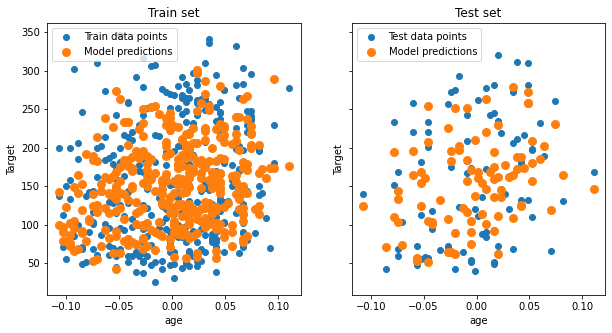

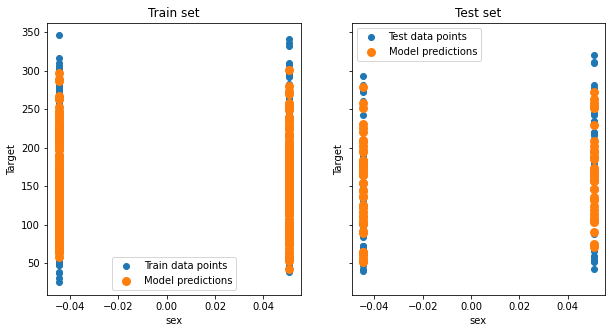

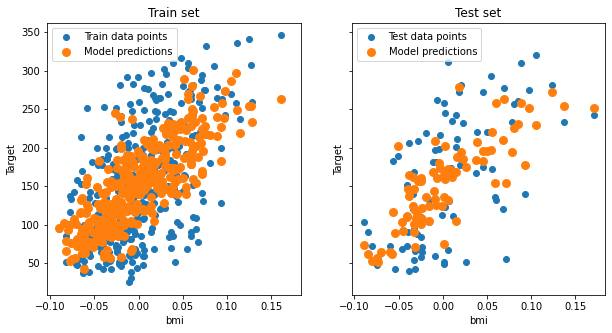

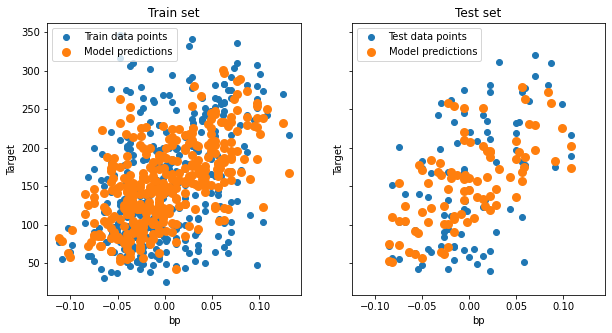

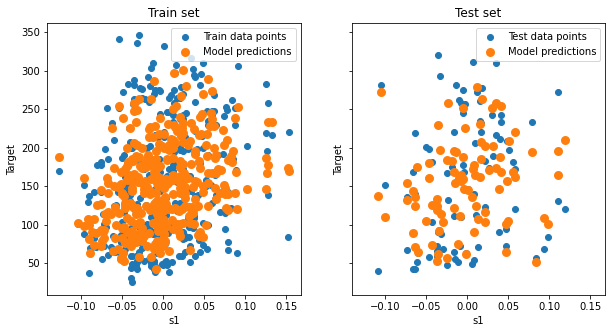

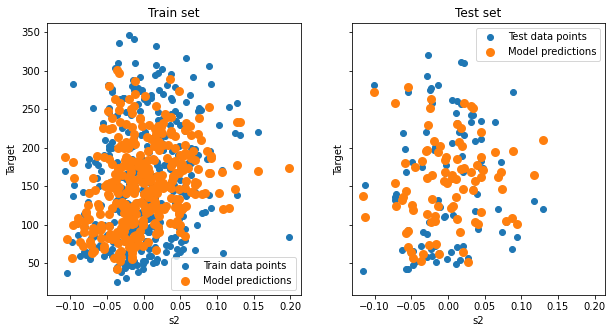

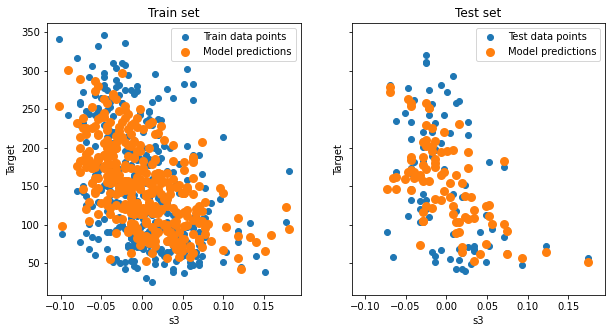

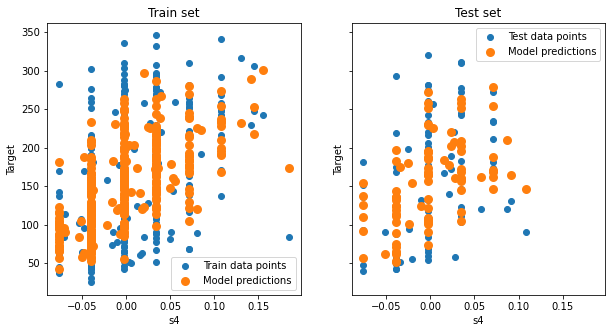

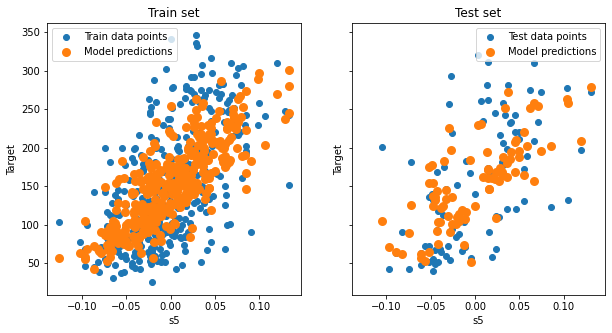

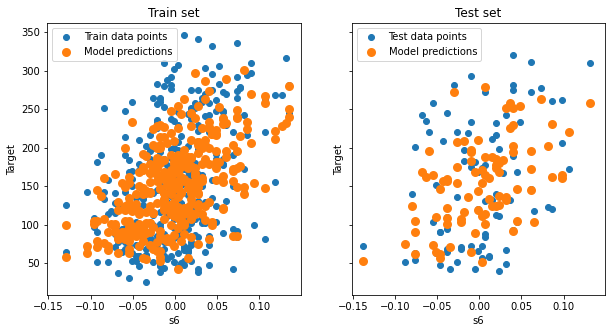

In [580]:
for feature in X.columns:
    plot_results(feature)